# Recommendation System

## User-Based Collaborative Filtering

## Notebook by [WenyiXu](https://github.com/xuwenyihust)

### Loading the data

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr

from sklearn import cross_validation

fulldf=pd.read_csv("https://raw.githubusercontent.com/xuwenyihust/Recommendation-Systems/master/data/amazon-fine-foods.csv")
fulldf = fulldf[:20000]

C:\Users\Wenyi Xu\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (1,2,3,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
print(fulldf.head(5))
print(fulldf.shape)

    Id   ProductId          UserId                      ProfileName  \
0  1.0  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1  2.0  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2  3.0  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3  4.0  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4  5.0  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score          Time  \
0                   1.0                     1.0    5.0  1.303862e+09   
1                   0.0                     0.0    1.0  1.346976e+09   
2                   1.0                     1.0    4.0  1.219018e+09   
3                   3.0                     3.0    2.0  1.307923e+09   
4                   0.0                     0.0    5.0  1.350778e+09   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitalit

### Brief Exploratory analysis

In [34]:
print(fulldf.shape)
print(fulldf['UserId'].unique().shape)
print(fulldf['ProductId'].unique().shape)

(20000, 10)
(17677,)
(2657,)


We can see that the number of unique users are much larger than the number of unique items.

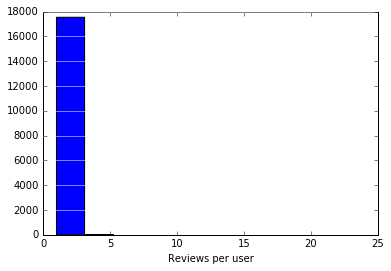

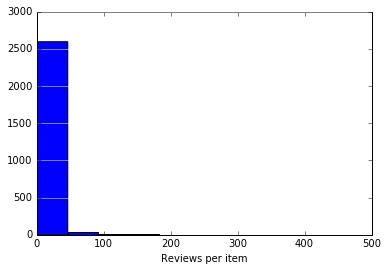

In [35]:
plt.figure()
ax=fulldf.groupby('UserId')['ProductId'].count().hist()
plt.xlabel("Reviews per user")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')

plt.figure()
ax=fulldf.groupby('ProductId')['UserId'].count().hist()
plt.xlabel("Reviews per item")
plt.grid(False)
plt.grid(axis = 'y', color ='white', linestyle='-')

The plots show that most users reviewed on less than 4 item. And most items have less than 50 reviews.

In this case, there will be very small number of co-rated items or even no such one between 2 users.

This may lead to a bad result.

### Reduce Sparsity

Reduce the sparsity of the data set, construct a new smalldf.

### Train/Test Split

Split the train & test dataset, use the train subset to train the model, and validate the model using test subset.

In [ ]:
X = smalldf[['Id', 'ProductId', 'UserId']]
y = smalldf[['Score']]

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print(X_train.head(5))
print(X_test.head(5))

### User-item matrix construction

Transform the original table into a user-item matrix

In [33]:
traindf = X_train
traindf.loc[:,'Score'] = y_train
print(traindf.head(5))
matrix = traindf.pivot_table(index='UserId', columns='ProductId', values='Score')
print(matrix.shape)
print(matrix.head(5))

          Id   ProductId          UserId  Score
5894  5895.0  B003KLSZGW  A1DXTSHQEVQJTR    5.0
3728  3729.0  B004SFNFEG  A3SIZC600PA0AW    5.0
8958  8959.0  B0007A0AP8  A1OI15XSWJ8FFX    5.0
7671  7672.0  B001E5DZTS  A1JY70V80B1F78    5.0
5999  6000.0  B003SE52K8   AJNSMUB2HU1M8    5.0

C:\Users\Wenyi Xu\Anaconda3\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s



(14425, 2405)
ProductId       B00002NCJC  B00002Z754  B00005V3DC  B000084DVR  B000084E1U  \
UserId                                                                       
A1001TYW5FZYD9         NaN         NaN         NaN         NaN         NaN   
A1003ACBU13X6E         NaN         NaN         NaN         NaN         NaN   
A1004703RC79J9         NaN         NaN         NaN         NaN         NaN   
A10080F3BO83XV         NaN         NaN         NaN         NaN         NaN   
A1011I2PCI4K8B         NaN         NaN         NaN         NaN         NaN   

ProductId       B000084EK4  B000084EK5  B000084EK6  B000084EK7  B000084EK8  \
UserId                                                                       
A1001TYW5FZYD9         NaN         NaN         NaN         NaN         NaN   
A1003ACBU13X6E         NaN         NaN         NaN         NaN         NaN   
A1004703RC79J9         NaN         NaN         NaN         NaN         NaN   
A10080F3BO83XV         NaN         NaN         N

### User-to-user similarity

Define a function to compute the similarities between users.

Based on Pearson correlation.

In [18]:
def com_sim(reviews_user0, reviews_user1):
    return pearsonr(reviews_user0['Score'], reviews_user1['Score'])[0] 

### Get items that a user has reviewed

In [7]:
def items_reviewed(user):
    return traindf[traindf['UserId'] == user]['ProductId'].unique()

### Reviews for common items

In [8]:
def common_items(user0, user1):
    user0_items = items_reviewed(user0)
    user1_items = items_reviewed(user1)
    return set(user0_items).intersection(user1_items)

### Get reviews of a given list of items rated by a given user

In [13]:
def get_user_reviews(user, set_of_items):
    mask = (traindf['ProductId'].isin(set_of_items)) & (traindf['UserId']==user)
    reviews = traindf[mask]
    reviews = reviews[reviews.UserId.duplicated()==False]
    return reviews

### K nearest users

Given an active user and an item that hasn't been rated by him/her, find the K nearest users to that active one that have rated the item.

In [25]:
def k_nearest(user0, k):
    all_users = traindf['UserId'].unique().tolist()
    knu = []
    for user1 in all_users:
        if user0 != user1:
            # Get the items that reviewed by both users
            both_items = common_items(user0, user1)
            # Get the sub-dataframe containing the intersected items by these 2 users
            reviews_user0 = get_user_reviews(user0, both_items)
            reviews_user1 = get_user_reviews(user1, both_items)
            if len(both_items) == 0:
                sim = 0
            else:
                sim = com_sim(reviews_user0, reviews_user1)
            if len(knu) < k:
                knu.append([user1, sim])
                knu = sorted(knu, key=lambda similarity: similarity[1], reverse=True)
            else:
                if sim > knu[-1][1]:
                    knu[-1] = [user1, sim]
                    knu = sorted(knu, key=lambda similarity: similarity[1], reverse=True)
    return knu

### K nearest users test

Test the K nearest users function

In [32]:
print(k_nearest('A1004703RC79J9', 1))
print(k_nearest('A1001TYW5FZYD9', 1))
print(k_nearest('A10080F3BO83XV', 1))

[['A1DXTSHQEVQJTR', 0]]
[['A1DXTSHQEVQJTR', 0]]
[['A1DXTSHQEVQJTR', 0]]
